In [1]:
# Libraries
from google.colab import files
import pandas as pd
from fastai.text.all import *
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

In [2]:
uploaded = files.upload()

Saving sampled_books.csv to sampled_books.csv


In [3]:
df = pd.read_csv("sampled_books.csv")
df.head()

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,B0006CR6U4,"A dictionary of the Targumim, the Talmud Babli and Yerushalmi, and the Midrashic literature",NaN,A303XPDO694V6X,Ariel,2/6,4.0,1122163200,Jastrow,"Jastrow made a great workthis dictionary can help you to learn any aramaic textbut in my case help me a lot to learn the talmud.It is difficult to thread one's way through its massive pages unless assisted by the helpful experts who contrive systematic directives -'who make handles to the Torah'- to meet the varied approaches of those who seek to know its wisdom and doctrine, its laws and its poetry, its folklore and even its apparent trivia. The well-known Midrash comes to mind.King Solomon applied his wisdom and prudence to help students find their way through the intricacies of the Tora..."
1,0897166159,Espresso Coffee: Professional Techniques,NaN,A3780H4TM9RMB8,David barnes,0/1,2.0,1356912000,NOT the book,Extremely disappointed by the SHORT length and cursory information of this video.The barista knows his stuff. Better buy his book.
2,0736693408,The First King of Shannara (The Sword of Shannara),NaN,A1AX6VPDQQZDPV,M Carlton,4/4,5.0,1105574400,Great (what do you expect?),"This, like all of Brook's Shannara series books, is wonderful. I am glad that Brooks took the opportunity to write this prequel. It gives the reader a look into the past and into the characters and ancestors that started the story that continues through the Shannara series. The characters are very well developed and rich, without the droning on and on with descriptions that some authors fault. You learn little bits and pieces at a time about the characters and story that continually make you go ""Aha! So that's why....."" Moves along at a great pace and keeps you wondering, but with enough h..."
3,0395051029,Wuthering Heights (Riverside editions),NaN,A35RQKCCCQ62O0,LadyJ,0/0,4.0,1353888000,Satisfied,I enjoyed this classic. I didn't know the story prior to reading it and once I adjusted to the older style prose it was a pleasant read.
4,4770016050,"A Cat, a Man, and Two Women (Japans Modern Writers)",NaN,A2IJQDE1I4SIJT,"David C. Arnold ""master D""",1/2,5.0,1167955200,"Ordered 09/02/2006, still on backorder","I would love to read this book. Have accepted slip in delivery by Amazon three times. Eventually, when it arrives, I'll read it.(Amazon asked me to review ""this recent purchase"" on 03Jan07 ...)(Amazon, you're great - but track who who ask to review what a bit closer ...)"


In [4]:
df = df.rename(columns = {"review/score": "rating", "review/text": "review"})

In [5]:
def label_sentiment(rating):
    if rating >= 4:
        return 1  # Positive sentiment
    elif rating <= 2:
        return 0  # Negative sentiment
    else:
        return 0.5  # Neutral sentiment

df["sentiment"] = df["rating"].apply(label_sentiment)
df = df[["review", "sentiment"]]

df.head()

,review,sentiment
0,"Jastrow made a great workthis dictionary can help you to learn any aramaic textbut in my case help me a lot to learn the talmud.It is difficult to thread one's way through its massive pages unless assisted by the helpful experts who contrive systematic directives -'who make handles to the Torah'- to meet the varied approaches of those who seek to know its wisdom and doctrine, its laws and its poetry, its folklore and even its apparent trivia. The well-known Midrash comes to mind.King Solomon applied his wisdom and prudence to help students find their way through the intricacies of the Tora...",1.0
1,Extremely disappointed by the SHORT length and cursory information of this video.The barista knows his stuff. Better buy his book.,0.0
2,"This, like all of Brook's Shannara series books, is wonderful. I am glad that Brooks took the opportunity to write this prequel. It gives the reader a look into the past and into the characters and ancestors that started the story that continues through the Shannara series. The characters are very well developed and rich, without the droning on and on with descriptions that some authors fault. You learn little bits and pieces at a time about the characters and story that continually make you go ""Aha! So that's why....."" Moves along at a great pace and keeps you wondering, but with enough h...",1.0
3,I enjoyed this classic. I didn't know the story prior to reading it and once I adjusted to the older style prose it was a pleasant read.,1.0
4,"I would love to read this book. Have accepted slip in delivery by Amazon three times. Eventually, when it arrives, I'll read it.(Amazon asked me to review ""this recent purchase"" on 03Jan07 ...)(Amazon, you're great - but track who who ask to review what a bit closer ...)",1.0


In [6]:
# Split data for training and validation
splits = RandomSplitter(valid_pct = 0.2)(range_of(df))

In [7]:
# Language model fine-tuning
dls_lm = TextDataLoaders.from_df(df, text_col = "review", is_lm = True, splits = splits)
learn_lm = language_model_learner(dls_lm, AWD_LSTM, drop_mult = 0.3)
learn_lm.fine_tune(4, base_lr = 1e-3)
learn_lm.save_encoder('fine_tuned_lm')

/usr/local/lib/python3.10/dist-packages/fastai/text/learner.py:149: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  wgts = torch.load(wgts_fname, map_location = lambda storage

epoch,train_loss,valid_loss,time
0,4.311602,4.162533,00:27


epoch,train_loss,valid_loss,time
0,4.164927,4.057822,00:31
1,4.062345,3.993709,00:32
2,3.990668,3.969226,00:32
3,3.947715,3.965067,00:32


In [8]:
# Text classification setup using the fine-tuned language model encoder
dls_clas = TextDataLoaders.from_df(df, text_col = "review", label_col = "sentiment", bs = 64, splits = splits)
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult = 0.4, metrics = accuracy)
learn.load_encoder('fine_tuned_lm')
learn.fine_tune(4, base_lr = 1e-3)

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


/usr/local/lib/python3.10/dist-packages/fastai/text/learner.py:149: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  wgts = torch.load(wgts_fname, map_location = lambda storage

epoch,train_loss,valid_loss,accuracy,time
0,1.137551,1.035939,0.486667,00:10


epoch,train_loss,valid_loss,accuracy,time
0,0.983081,0.910687,0.595000,00:22
1,0.930630,0.826255,0.695000,00:23
2,0.861230,0.770377,0.728333,00:23
3,0.807832,0.780283,0.728333,00:22


In [9]:
# Gradual unfreezing and tuning
learn.freeze_to(-2)
learn.fit_one_cycle(1, 1e-3)
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(1e-4, 1e-3))
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.788763,0.711739,0.766667,00:11


epoch,train_loss,valid_loss,accuracy,time
0,0.671060,0.690531,0.771667,00:18


epoch,train_loss,valid_loss,accuracy,time
0,0.561090,0.659094,0.783333,00:23
1,0.547637,0.663319,0.778333,00:22


In [10]:
# Validation and prediction example
text = "This is an amazing book! I couldn't put it down."
preds = learn.predict(text)
print(f'Text: "{text}"')
print(f'Predicted sentiment: {preds[0]}')

Text: "This is an amazing book! I couldn't put it down."
Predicted sentiment: 1.0


In [11]:
# Model evaluation with confusion matrix and classification report
preds, targets = learn.get_preds(dl = dls_clas.valid)
pred_labels = preds.argmax(dim = 1)

ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of labels (2).

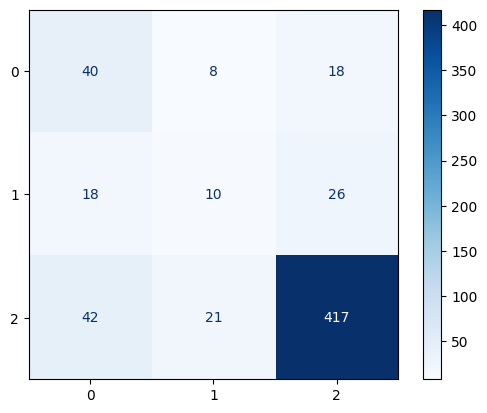

In [12]:
# Display confusion matrix
cm = confusion_matrix(targets, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = dls_clas.vocab)
disp.plot(cmap = "Blues", values_format = "d")
plt.title("Confusion Matrix for Sentiment Analysis Model")
plt.show()

In [13]:
target_names = ["Negative", "Neutral", "Positive"]
report = classification_report(targets, pred_labels, target_names = target_names)
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

    Negative       0.40      0.61      0.48        66
     Neutral       0.26      0.19      0.22        54
    Positive       0.90      0.87      0.89       480

    accuracy                           0.78       600
   macro avg       0.52      0.55      0.53       600
weighted avg       0.79      0.78      0.78       600

